Imports and libraries

In [1]:
import pymongo
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import pickle as pkl
import random
import argparse
import pickle
from collections import Counter
import ast
from tqdm import tqdm
from os.path import join
from bson.objectid import ObjectId
import requests
import missingno
import time
from keras.utils.vis_utils import plot_model
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing import image
from keras.models import Model, load_model
import nltk.data
from nltk import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import gensim
from gensim.models import FastText
import re, unicodedata
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem import SnowballStemmer
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, \
UpSampling1D, LSTM, RepeatVector, TimeDistributed
from keras.utils import plot_model
import os
pd.set_option('max_colwidth', -1)
%matplotlib inline
plt.style.use('ggplot')
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
UpSampling1D, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, concatenate, \
Reshape, Dropout, BatchNormalization, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.utils import plot_model, to_categorical
from sklearn.neighbors import NearestNeighbors

import os, sys
import numpy as np
import seaborn as sns
import gc
import warnings
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from gensim.models import Word2Vec
from keras.regularizers import l1, l2
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
LSTM, GRU, concatenate, Bidirectional, \
Reshape, Dropout, GlobalAveragePooling1D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

pd.set_option('max_colwidth', 250)
warnings.filterwarnings(action='once')

Using TensorFlow backend.
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Jo

# DATA COLLECTION

**Global Variables**

In [2]:
USERNAME = os.environ['JEWEL_JOEL_USERNAME']
PASSWORD = os.environ['JEWEL_JOEL_PASSWORD']
URL2 = "mongodb+srv://" + USERNAME + ":" + PASSWORD + "@logger-dev1.ourip.gcp.mongodb.net/warehouse_logger_db?retryWrites=true&w=majority"
URL1 = "mongodb+srv://" + USERNAME + ":" + PASSWORD + "@app-cluster-dev1.ourip.gcp.mongodb.net/app_jewel_standard_db?retryWrites=true&w=majority"
client = "5d42f6ddfe182b4831e20fe7"  #madeiramadeira.com.br
threshold = 11000

**Connections to the database and Data Retrieval**

In [3]:
cursor = pymongo.MongoClient(URL2).warehouse_logger_db.clicks.aggregate([
    { "$limit": threshold},    
    {"$match": {"integration_id": client}},
    { "$group": {
                "_id": {'session_id': '$user_fingerprint',
                        'date_time': '$createdat',
                        'item_id': '$item_id',
                        #'Category': '$integration_category',
                        'price': '$item_price',
                        'brand': '$item_brand',
                        'title': '$item_title'
                        }
                }
    }
],  allowDiskUse = True  )

data = [x['_id'] for x in cursor]

clicks_df = pd.DataFrame.from_dict(data)
clicks_df.item_id = clicks_df.item_id.str.strip()
print(clicks_df.shape)

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\pymongo\srv_resolver.py:73: DeprecationWarning: please use dns.resolver.resolve() instead
  lifetime=self.__connect_timeout)


(10909, 6)


In [4]:
cursor = pymongo.MongoClient(URL1).app_jewel_standard_db.catalogitems.aggregate([
    { "$limit": threshold},    
    {"$match": {"associated_integration": ObjectId(client), "active": True}},
    { "$group": {
                    "_id": {"item_id":"$standard_features.item_id",
                            'category': '$standard_features.categories',
                            #'price': '$standard_features.sale_price',
                            #'currency': '$standard_features.content_currency_code',
                            'brand': '$standard_features.brand',
                            'title': '$title',
                            'image': '$standard_features.image_url_src'
                            #'description': '$description'
                        }
                }
    }
],  allowDiskUse = True  )

data = [x['_id'] for x in cursor]

items_df = pd.DataFrame.from_dict(data)
print(items_df.shape)

(576, 5)


In [5]:
#Fixing IDs
items_df['item_id'] = items_df.item_id.map(lambda x: x.split(":")[3])

#No spaces in among categories' strings
items_df['category'] = items_df.category.map(lambda x: [d['value'].lower() for d in x])
items_df['category'] = items_df.category.map(lambda x: str(sorted(x, key=str.lower)))

for i, lista in enumerate(items_df['category'].values):
    items_df['category'].values[i] = ast.literal_eval(lista)
for i, elem in enumerate(items_df['category']):
    items_df['category'].values[i] = [x.replace(" ", "_") for x in elem ]

items_df['category'] = items_df['category'].apply(lambda x: '_'.join(x))
items_df_copy = items_df

**Downloading Images**

In [6]:
images_df = items_df[['item_id', 'image']]
images_df.head()

item_id  \
0   207160   
1  1019094   
2  1010223   
3  1019129   
4   364066   

                                                                                                                                                                   image  
0  https://images.madeiramadeira.com.br/prd/viero-moveis/207160/conjunto-sala-de-jantar-mesa-tampo-preto-e-4-cadeiras-filty-siena-moveis-choco-canela-90-170406_zoom.jpg  
1                                                                   https://cormilu.com.br/cormilu-content/uploads/2017/04/Cordão-de-luz-Toulouse-SUPORTE-BRANCO-OFF.jpg  
2                                                                                  https://cdn2.madeiramadeira.com.br/floripa-kit-20-bolas-a-pilha7908048500588-11-1.jpg  
3                                                                https://cormilu.com.br/cormilu-content/uploads/2017/04/Cordão-de-luz-Monte-Carlo-SUPORTE-BRANCO-OFF.jpg  
4                                  https://img1.madeiramadeira.com.br/prd/m-veis-henn/364066/quarto-infantil-com-ber-o-flex-happy-c-moda-happy-siena-m-veis-195_zoom.jpg

In [7]:
images_path = "images/"

image_list = sorted(os.listdir(images_path))
for i, img in enumerate(image_list):
    if i % 5 != 0:
        img_path = os.path.join(images_path,img)
        os.remove(img_path)

image_errors = []

for index, row in images_df.iterrows():
    if index % 100 == 0:
        print ('A total of ' + str(index) + ' images are downloaded')

    filename = row['item_id'] + '.jpg'

    with open(images_path + filename, 'wb') as img_file:
        try:
            callback = requests.get(row['image'], stream=True)

            if callback.ok:

                for batch in callback.iter_content(1024):
                    if not batch:
                        break

                    img_file.write(batch)
            else:
                print(f'Status code error with {callback.status_code} code.')

        except Exception as e:
            print(f'Error: {e}')
            image_errors.append(row['image'])
            time.sleep(3)
            pass

print("Finished Downloading Images.")

image_errors = set(image_errors)

if not image_errors:
    print("No errors detected.")
else:
    print("Errors in downloading images were detected: ")
    for error in image_errors:
        print(error)


A total of 0 images are downloaded
A total of 100 images are downloaded
A total of 200 images are downloaded
A total of 300 images are downloaded
A total of 400 images are downloaded
A total of 500 images are downloaded
Finished Downloading Images.
No errors detected.


# EXPLORATORY ANALYSIS

In [8]:
clicks_df = clicks_df.replace('', np.NaN)

(10909, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10909 entries, 0 to 10908
Data columns (total 6 columns):
session_id    10909 non-null object
date_time     10909 non-null datetime64[ns]
item_id       6600 non-null object
price         6574 non-null object
brand         0 non-null float64
title         10879 non-null object
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 511.5+ KB
None
                         session_id               date_time item_id     price  \
0  e06c805b50dd8bcd57b4639c0f267c22 2020-07-27 01:14:17.501  590554    147,15   
1  c789e3e9fb5cf773ef18fc915056f702 2020-07-27 01:14:17.487  282032   159,50    
2  20a21a2c8d0850f777e6f7fee243fcfc 2020-07-27 01:14:17.489     NaN       NaN   
3  fd38e1e98aaed646f0a3cf36df1eaa25 2020-07-27 01:14:17.479     NaN       NaN   
4  cd1e273a294606b909e4ee2e333a1478 2020-07-27 01:14:17.473  350134  1.082,90   

   brand  \
0    NaN   
1    NaN   
2    NaN   
3    NaN   
4    NaN   

                        

session_id        0
date_time         0
item_id        4309
price          4335
brand         10909
title            30
dtype: int64

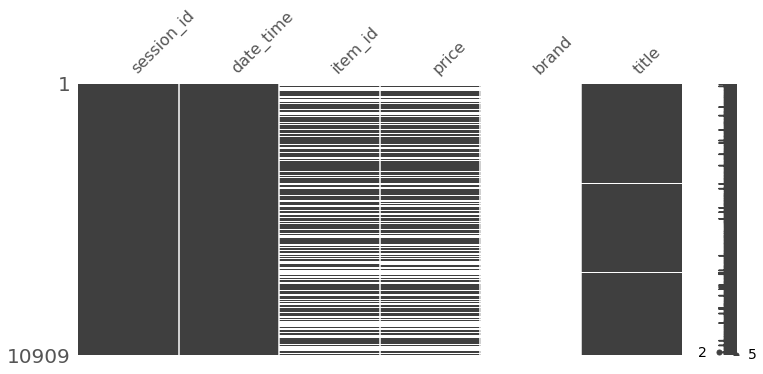

In [9]:
# Preview Clicks
print(clicks_df.shape)
print(clicks_df.info())
print(clicks_df.head())

print(clicks_df.describe(include = 'all')) #it helps to understand non-sense values

#missing values
missingno.matrix(clicks_df, figsize=(12, 5))
clicks_df.isnull().sum()

**Number of Clicks Per Item**

#TODO:

**Number of Clicks Per Number of Users**

#TODO:

**Number of Clicks Per Price Ranges**

#TODO:

**Number of Clicks Throughout Time**

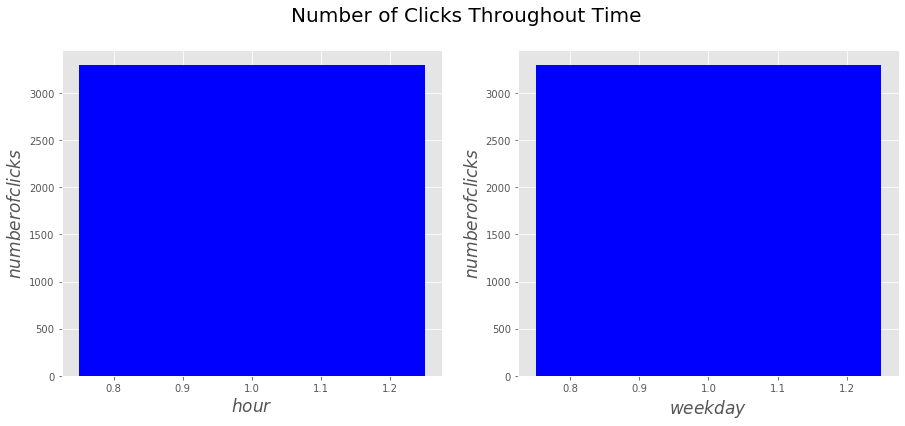

In [10]:
clicks_df['date_time']=pd.to_datetime(clicks_df.date_time)
clicks_df['hour']=clicks_df.date_time.dt.hour
clicks_df['weekday']=clicks_df['date_time'].dt.dayofweek.astype(int)+1

click_hour_info = clicks_df.groupby(['hour'])['session_id'].nunique().reset_index(name='count_h_c')
click_weekday_info = clicks_df.groupby(['weekday'])['session_id'].nunique().reset_index(name='count_w_c')


fig = plt.figure(figsize=(15,6))
fig.suptitle('Number of Clicks Throughout Time', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.bar(click_hour_info['hour'],click_hour_info['count_h_c'],width=0.5,color='b')


ax1.set_xlabel('$hour$', fontsize=17)
ax1.set_ylabel('$number of clicks$', fontsize=17)

ax2.bar(click_weekday_info['weekday'],click_weekday_info['count_w_c'],width=0.5,color='b')

ax2.set_xlabel('$weekday$', fontsize=17)
ax2.set_ylabel('$number of clicks $', fontsize=17)
plt.show()

In [11]:
items_df = items_df.replace('', np.NaN)

(576, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 5 columns):
item_id     576 non-null object
category    576 non-null object
brand       576 non-null object
title       576 non-null object
image       576 non-null object
dtypes: object(5)
memory usage: 22.6+ KB
None
   item_id                                             category         brand  \
0   207160    mesas_mesas_de_cozinha_e_de_sala_de_jantar_móveis  Siena Móveis   
1  1019094  fios_e_árvores_de_luz_iluminação_iluminação_led_led       Cormilu   
2  1010223  fios_e_árvores_de_luz_iluminação_iluminação_led_led       Cormilu   
3  1019129  fios_e_árvores_de_luz_iluminação_iluminação_led_led       Cormilu   
4   364066                              quarto_de_bebê_completo  Siena Móveis   

                                                                              title  \
0  Conjunto Sala de Jantar Mesa em Vidro 4 Cadeiras Filty Siena Móveis Choco/Canela   
1                   

item_id     0
category    0
brand       0
title       0
image       0
dtype: int64

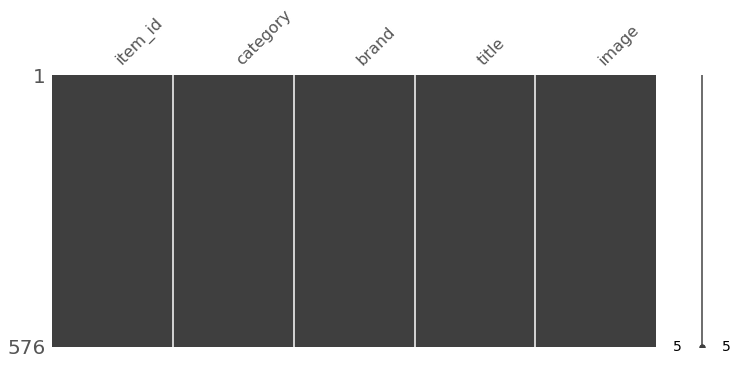

In [12]:
# Preview Items
print(items_df.shape)
print(items_df.info())
print(items_df.head())
pd.set_option('display.max_columns', 100)

#missing values
missingno.matrix(items_df, figsize=(12, 5))
items_df.isnull().sum()

**Distribution of Items per Category**

#TODO:

**Distribution of Items per Brand**

#TODO:

removing values

In [13]:
clicks_df = clicks_df[clicks_df['item_id'].notna()]

#imputing price missing values as 0
clicks_df['price'].fillna(0, inplace=True)

In [14]:
print(items_df.duplicated().sum())

0


# Standardization

In [15]:
def normalize(words, p_brands, STOPWORDS_ALL, lemmatizer_inv):

    new_words = []
    for word in words:
        new_word = word.lower()
        new_word = re.sub(r'[^\w\s]', '', new_word)
        if new_word != '' and new_word not in p_brands and new_word not in STOPWORDS_ALL and len(new_word) > 1: #remove stopwords, brands and punctuation
            new_words.append(new_word)
    words = new_words

    lemmas = []
    for word in words:
        if word in lemmatizer_inv:
            lemmas.append(lemmatizer_inv[word]) #lemmatize verbs
        else: lemmas.append(word)
    words = lemmas


    new_words = []
    for word in words:
        if not word.isdigit():
            new_words.append(word) #remove numbers
    words = new_words


    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') #remove non-ascii
        new_words.append(new_word)


    words = list(dict.fromkeys(new_words)) #Remove duplicates
    words = " ".join(words)
    return words

In [16]:
def normalizing(strings):
    strings = str(strings)
    strings  = strings.strip().split()

    normalized = []
    for s in strings:
        word_temp = s.lower()
        word_temp = re.sub(r'[^\w\s]', '', word_temp) #remove punctuation
        if word_temp != '':
            normalized.append(word_temp)

    normalized_words = list(dict.fromkeys(normalized)) #Removing duplicated brands
    normalized_words = " ".join(normalized_words)
    return normalized_words

In [17]:
items_df['brand'].value_counts() # We see the need for brands to be normalized

Lorenzetti            71
NETSOFAS              57
Nagano                53
Taschibra             45
Rifletti Estofados    37
                      ..
AVANT                  1
JCM Móveis             1
Móveis Cavazotto       1
DECA                   1
Meber Metais           1
Name: brand, Length: 85, dtype: int64

In [18]:
items_df['title'].value_counts()

Sofá 4 Lugares Canto com Chaise Retrátil Miró Velosuede 2,16m (L)                               6
Sofá 6 Lugares Roma Retrátil e Reclinável Suede Amassado Rifletti                               5
Sofá 4 Lugares Net Jaguar Assento Retrátil e Reclinável 2,30m (L)                               5
Poltrona em Madeira Maciça Lotus Casa e Jardim Móveis Stain Castanho                            1
Suporte para Furadeira com Morsa e Escala - NSFME                                               1
                                                                                               ..
Transpalete hidráulico roda dupla de nylon 550 x 1220 mm 2000 Kg - TTDN550                      1
Torneira de Parede para Cozinha 1156P37 1/4 de Volta Japi Cromado                               1
Conjunto Sala de Jantar Mesa 6 Cadeiras Cristiane Siena Móveis Veludo Creme/Off White/Imbuia    1
Refil para Esfregão MOP Limpeza Prática Mor                                                     1
Lustre Pendente Tasc

In [19]:
items_df['brand'] = items_df['brand'].apply(normalizing)
brands = list(dict.fromkeys(items_df['brand'].values))

nltk.download('stopwords')


STOPWORDS_PT = list(set(stopwords.words('portuguese')))
STOPWORDS_ENG = list(set(stopwords.words('english')))
CUSTOM  = []  #TODO:There are custom stop word that sould've been added here

STOPWORDS_ALL = STOPWORDS_PT + STOPWORDS_ENG + CUSTOM


lemmatizer_dict = {}
with open('lemmatization-pt.txt', encoding= 'UTF-8') as f:
    for line in f:
        try:
            (key, val) = line.split()
        except:
            pass
        lemmatizer_dict[str(key)] = val

lemmatizer = {v: k for k, v in lemmatizer_dict.items()}

words = [word.split() for word in items_df['title'].values]


for i in range(len(words)):
    items_df['title'].values[i] = normalize(words = words[i], p_brands = brands,
                                                    STOPWORDS_ALL = STOPWORDS_ALL,
                                                    lemmatizer_inv = lemmatizer)

[nltk_data] Downloading package stopwords to C:\Users\Joel
[nltk_data]     Pires\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
items_df['title']

0      conjunto sala jantar mesa vidro cadeiras filty siena movel chococanela
1                                            fio luz led toulouse bolas pilha
2                                                     floripa kit bolas pilha
3                                          fio luz led monte carlo bolas 110v
4                    conjunto berco mini cama comoda happy siena movel branco
                                        ...                                  
571                                              lustre pendente td preto e27
572             sofa lugar net logan assentir retratil reclinavel marrom 209m
573                                               sofa cama done linho bronze
574                                            prateleira cromada lorenquadra
575                          chuveiro duo shower quadra eletronica turbo 220v
Name: title, Length: 576, dtype: object

# Word2Vec

In [21]:
EMBEDDING_DIMENSION = 100   #TODO: OPTIMIZE HYPERPARAMETER

In [22]:
phrases = [word.split() for word in items_df['title'].values]
model_W2V = Word2Vec(phrases, workers = 3, min_count=5, window = 10, size = EMBEDDING_DIMENSION)
model_W2V.train(phrases, total_examples=len(phrases), epochs=50)

(62765, 195650)

In [23]:
model_W2V.save('W2V_model')

In [24]:
#just a test
wl = 'sofa'
model_W2V.wv.most_similar (positive = wl)   #yes it's similar =D

[('retratil', 0.9996851682662964),
 ('lugar', 0.9996710419654846),
 ('reclinavel', 0.9992871880531311),
 ('pillow', 0.9959809184074402),
 ('ethios', 0.9951597452163696),
 ('rifletti', 0.9934531450271606),
 ('connect', 0.9928992390632629),
 ('pena', 0.9912598133087158),
 ('treviso', 0.9910249710083008),
 ('amassado', 0.9895956516265869)]

## Vectorize Sentences

In [25]:
bag_words = nltk.word_tokenize(items_df['title'].to_string())
bag_words = list(dict.fromkeys(bag_words))

In [26]:
MAX_NUMBER_WORDS = len(bag_words)
MAX_LENGTH_SEQUENCE = 24  #TODO: OPTIMIZE HYPERPARAMETER

In [27]:
all_titles = items_df['title']
all_titles = all_titles.drop_duplicates(keep = False)

In [28]:
all_titles

0      conjunto sala jantar mesa vidro cadeiras filty siena movel chococanela
1                                            fio luz led toulouse bolas pilha
2                                                     floripa kit bolas pilha
3                                          fio luz led monte carlo bolas 110v
4                    conjunto berco mini cama comoda happy siena movel branco
                                        ...                                  
570                         poltrona jardim primavera casa movel stain jatoba
572             sofa lugar net logan assentir retratil reclinavel marrom 209m
573                                               sofa cama done linho bronze
574                                            prateleira cromada lorenquadra
575                          chuveiro duo shower quadra eletronica turbo 220v
Name: title, Length: 501, dtype: object

In [29]:
tokenizer = Tokenizer(num_words=MAX_NUMBER_WORDS, )
tokenizer.fit_on_texts(all_titles)

sequences = tokenizer.texts_to_sequences(items_df['title'])
vectors = pad_sequences(sequences, maxlen=MAX_LENGTH_SEQUENCE)

In [30]:
indexes = tokenizer.word_index
word_vecs = model_W2V.wv
vocab_size = len(indexes) + 1
emb_matrix = np.zeros((len(indexes) + 1, EMBEDDING_DIMENSION))

for word, i in indexes.items():
    if word in model_W2V:
        emb_matrix[i] = model_W2V[word]
    else:
        emb_matrix[i] = np.random.rand(1, EMBEDDING_DIMENSION)[0]


del(word_vecs)

emb_layer = Embedding(input_dim = vocab_size,
                            output_dim = EMBEDDING_DIMENSION,
                            input_length = MAX_LENGTH_SEQUENCE,
                            weights=[emb_matrix],
                            name='w2vEmb',
                            trainable=False)

model_W2V.save("w2vEmb.h5")

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


# Dense Layer

In [31]:
XTrain = np.vstack(vectors)
model = Sequential()
model.add(emb_layer)
model.compile('rmsprop', 'mse')
model.summary()

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:497: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:115: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.float_val.extend([np.asscalar(x) for x in proto_values])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
w2vEmb (Embedding)           (None, 24, 100)           113000    
Total params: 113,000
Trainable params: 0
Non-trainable params: 113,000
_________________________________________________________________


C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [32]:
input_i = Input(shape=(MAX_LENGTH_SEQUENCE, EMBEDDING_DIMENSION))
enc_layer_h1 = Dense(128, activation='relu')(input_i)
enc_layer_h2 = Dense(64, activation='relu')(enc_layer_h1)
enc_layer_h3 = Dense(32, activation='relu')(enc_layer_h2)
enc_layer_h4 = Dense(16, activation='relu')(enc_layer_h3)

latent = Dense(8, activation='relu', name = 'ENCODER')(enc_layer_h4)

dec_layer_h2 = Dense(16, activation='relu')(latent)
dec_layer_h3 = Dense(32, activation='relu')(dec_layer_h2)
dec_layer_h4 = Dense(64, activation='relu')(dec_layer_h3)
dec_layer_h5 = Dense(128, activation='relu')(dec_layer_h4)

output = Dense(EMBEDDING_DIMENSION, activation='relu')(dec_layer_h5)

auto_encoder = Model(input_i,output)

auto_encoder.compile('rmsprop','mse')
auto_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 24, 128)           12928     
_________________________________________________________________
dense_2 (Dense)              (None, 24, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 24, 32)            2080      
_________________________________________________________________
dense_4 (Dense)              (None, 24, 16)            528       
_________________________________________________________________
ENCODER (Dense)              (None, 24, 8)             136       
_________________________________________________________________
dense_5 (Dense)              (None, 24, 16)            144 

In [33]:
X_emb = model.predict(XTrain, verbose = 1)

576/576 [==============================] - 1s 1ms/step


In [34]:
auto_encoder.fit(X_emb,X_emb,epochs=3, batch_size=32, verbose = 1) #TODO: Optimize epochs and batch size

Epoch 1/3
576/576 [==============================] - 3s 4ms/step - loss: 0.0257
Epoch 2/3
576/576 [==============================] - 0s 564us/step - loss: 0.0205
Epoch 3/3
576/576 [==============================] - 0s 468us/step - loss: 0.0200


In [35]:
encoder_model = Model(inputs=auto_encoder.input, outputs=auto_encoder.get_layer('ENCODER').output)
encoder_model.save('encoder_text.h5')

# Find Similar Products using KNN

In [36]:
XTest = X_emb.copy()
request = X_emb[101]

In [37]:
results_coded = encoder_model.predict(XTest)
request_code = encoder_model.predict(request.reshape(1,MAX_LENGTH_SEQUENCE,EMBEDDING_DIMENSION))
results_coded = results_coded.reshape(-1, 24*8)
request_code = request_code.reshape(1, 24*8)

In [38]:
k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(results_coded)
distances, indexes = nbrs.kneighbors(np.array(request_code))

In [39]:
nearest = XTest[indexes]
nearest = nearest.reshape(-1,MAX_LENGTH_SEQUENCE,EMBEDDING_DIMENSION)

In [40]:
ind = indexes.tolist()[0]
for i in range(k):
    print (items_df.loc[ind[i]])
    print('-'*50)

item_id                                                                                                                                                    1759487
category                                                                                                                                              móveis_sofás
brand                                                                                                                                                     netsofas
title                                                                                                         sofa lugar canto chaise retratil miro velosuede 216m
image       https://img1.madeiramadeira.com.br/product/images/55755721-sofa-4-lugares-canto-com-chaise-retratil-miro-velosuede-2-16m-l-7908265700051-1-600x600.jpg
Name: 50, dtype: object
--------------------------------------------------
item_id                                                                                                       

# auto_encoder of Images

In [41]:
input_img = Input(shape=(100,100,3))

#Encoder
x = Conv2D(50, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2,2), padding='same', name='ENCODER')(x)

#Decoder

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(50, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

auto_encoder = Model(input_img, decoded)
auto_encoder.compile(optimizer='adam', loss='mse')
auto_encoder.summary()

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:497: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:115: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.float_val.extend([np.asscalar(x) for x in proto_values])


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 50)      1400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        14432     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 16)        4624      
_________________________________________________________________
ENCODER (MaxPooling2D)       (None, 13, 13, 16)        0   

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# TRAIN

In [42]:


errors = []
BATCH_SIZE = 128   #TODO: Optimize
X_df = np.zeros((BATCH_SIZE, 100, 100, 3))
count = 0

for fig in images_df['item_id'].loc[(100):(100 + BATCH_SIZE)]:
    count += 1
    try:
        img = image.load_img(images_path + fig + '.jpg', target_size=(100, 100, 3))
        x = image.img_to_array(img)

        X_df[count] = x

    except:
        errors.append(fig)
        pass

X_df = X_df/ 255

In [43]:
BATCH_SIZE = 128
STEP_SIZE = images_df.shape[0]//BATCH_SIZE
GLOBAL_EPOCHS = 1
total = 0

print(f'Training model in a total of {STEP_SIZE} steps..')

for epoch in range(0, GLOBAL_EPOCHS):

    total = 0
    print (f'==== EPOCH NUMBER {epoch} ====')

    for STEP in range(0, STEP_SIZE):
        errors = []
        BATCH_SIZE = 128   #TODO: Optimize
        X_df = np.zeros((BATCH_SIZE, 100, 100, 3))
        count = 0

        for fig in images_df['item_id'].loc[(total):(total + BATCH_SIZE)]:
            count += 1
            try:
                img = image.load_img(images_path + fig + '.jpg', target_size=(100, 100, 3))
                x = image.img_to_array(img)

                X_df[count] = x

            except:
                errors.append(fig)
                pass

        X_df = X_df/255

        auto_encoder.fit(X_df, X_df, epochs = 1, batch_size = BATCH_SIZE,
                callbacks = None, verbose = 0, shuffle=False )

        total += BATCH_SIZE
        print(f'Percentage: {STEP/STEP_SIZE}, Total Processed: {total}')

Training model in a total of 4 steps..
==== EPOCH NUMBER 0 ====
Percentage: 0.0, Total Processed: 128
Percentage: 0.25, Total Processed: 256
Percentage: 0.5, Total Processed: 384
Percentage: 0.75, Total Processed: 512


# AutoEncoder

In [44]:
auto_encoder.save('full_auto_encoder.h5')
auto_encoder = load_model('full_auto_encoder.h5')

# Encoder

In [45]:
encoder = Model(inputs=auto_encoder.input, outputs = auto_encoder.get_layer('ENCODER').output)

In [46]:
encoder.save('full_encoder.h5')

In [47]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 50)      1400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        14432     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 16)        4624      
_________________________________________________________________
ENCODER (MaxPooling2D)       (None, 13, 13, 16)        0   

## Visualize original image and reconstructed image

In [48]:

BATCH_SIZE = 1000
errors = []
XTrain = np.zeros((BATCH_SIZE, 100, 100, 3))
count = 0

for fig in images_df['item_id'].loc[(100):(100 + BATCH_SIZE)]:
    count += 1
    try:
        img = image.load_img(images_path + fig + '.jpg', target_size=(100, 100, 3))
        x = image.img_to_array(img)

        XTrain[count] = x

    except:
        errors.append(fig)
        pass

XTrain = XTrain/ 255

In [49]:
XTrain.shape

(1000, 100, 100, 3)

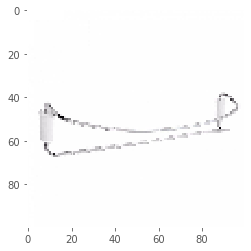

In [50]:
query = XTrain[150]  
plt.imshow(query)

### Encode the test images and the query image

In [51]:
XTest = XTrain.copy()
XTest.shape

(1000, 100, 100, 3)

In [52]:
codes = encoder.predict(XTest)
codes.shape
query_code = encoder.predict(query.reshape(1,XTrain.shape[1],XTrain.shape[2],XTrain.shape[3]))
query_code.shape

(1, 13, 13, 16)

### Find the closest images

In [53]:
codes = codes.reshape(-1, 13*13*16);
print(codes.shape)
query_code = query_code.reshape(1, 13*13*16);
print(query_code.shape)

(1000, 2704)
(1, 2704)


### Fit the KNN to the test set

In [54]:
n_neigh = 5
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)
distances, indices = nbrs.kneighbors(np.array(query_code))

In [55]:
closest_images = XTest[indices]
closest_images = closest_images.reshape(-1,100,100,3);
print(closest_images.shape)

(5, 100, 100, 3)


## Get the closest images

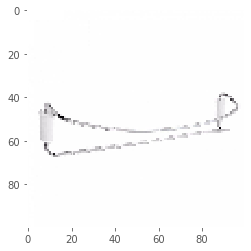

In [56]:
plt.imshow(query.reshape(100,100,3))

In [57]:
plt.figure(figsize=(20, 6))
for i in range(n_neigh):
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(100, 100,3))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Customers Data

In [58]:
clicks_df['brand'] = clicks_df['brand'].apply(normalizing)
brands = list(dict.fromkeys(clicks_df['brand'].values))

words = [word.split() for word in clicks_df['title'].values]


for i in range(len(words)):
    clicks_df['title'].values[i] = normalize(words = words[i], p_brands = brands,
                                                    STOPWORDS_ALL = STOPWORDS_ALL,
                                                    lemmatizer_inv = lemmatizer)

In [59]:
clicks_df.price = clicks_df.price.str.replace(',', '.')
clicks_df.price = clicks_df.price.apply(lambda x: pd.to_numeric(x, errors='coerce'))
clicks_df = clicks_df.dropna()

In [60]:
clicks_df.head()

session_id               date_time  item_id   price  \
0   e06c805b50dd8bcd57b4639c0f267c22 2020-07-27 01:14:17.501   590554  147.15   
1   c789e3e9fb5cf773ef18fc915056f702 2020-07-27 01:14:17.487   282032  159.50   
6   19ec0a7bafa0e53613eb6fefdc140ac4 2020-07-27 01:14:17.444  1177987   69.00   
8   1261de399c3051ec649f7b76c0c41ab1 2020-07-27 01:14:17.431   600498  117.70   
10  e57758c5236fab2df2d632af4bcf3522 2020-07-27 01:14:17.400   361099  167.41   

   brand                                                       title  hour  \
0    nan   painel tv polegada nicho mister espresso movel whitepinho     1   
1    nan       cabeceira casal criado mudo dormitorio decibal branco     1   
6    nan                        conjunto prato duralex opaline pecas     1   
8    nan  rack tv polegada rodizio aruba i movel bechara preto fosco     1   
10   nan                      painel tv polegada mister viero grigio     1   

    weekday  
0         1  
1         1  
6         1  
8         1  
10        1

### We need integer data to be able to feed the NN

In [61]:
customers_distinct = clicks_df.session_id.unique()
items_distinct = clicks_df.item_id.unique()
brand_distinct = clicks_df.brand.unique()

customers_map = {i:val for i,val in enumerate(customers_distinct)}
customers_map_inv = {val:i for i,val in enumerate(customers_distinct)}

mappend_items = {i:val for i,val in enumerate(items_distinct)}
mappend_items_inv = {val:i for i,val in enumerate(items_distinct)}

brands_map = {i:val for i,val in enumerate(brand_distinct)}
brands_map_inv = {val:i for i,val in enumerate(brand_distinct)}

In [62]:
clicks_df['session_idInt'] = clicks_df['session_id'].map(customers_map_inv)
clicks_df['item_idInt'] = clicks_df['item_id'].map(mappend_items_inv)
clicks_df['brand_id'] = clicks_df['brand'].map(brands_map_inv)
clicks_df.shape

(5217, 11)

In [63]:
data_score = clicks_df.groupby(['session_idInt', 'item_idInt']).size().to_frame('score').reset_index().sort_values(by = 'score',ascending = False)

In [64]:
df_final = pd.merge(clicks_df, data_score, how = 'inner')
df_final.shape

(5217, 12)

In [65]:

df_final.drop_duplicates(inplace=True)
df_final.dropna(how = 'any', inplace = True)

print(df_final.shape)
df_final.head()

(5217, 12)


session_id               date_time  item_id   price  \
0  e06c805b50dd8bcd57b4639c0f267c22 2020-07-27 01:14:17.501   590554  147.15   
1  c789e3e9fb5cf773ef18fc915056f702 2020-07-27 01:14:17.487   282032  159.50   
2  19ec0a7bafa0e53613eb6fefdc140ac4 2020-07-27 01:14:17.444  1177987   69.00   
3  1261de399c3051ec649f7b76c0c41ab1 2020-07-27 01:14:17.431   600498  117.70   
4  e57758c5236fab2df2d632af4bcf3522 2020-07-27 01:14:17.400   361099  167.41   

  brand                                                       title  hour  \
0   nan   painel tv polegada nicho mister espresso movel whitepinho     1   
1   nan       cabeceira casal criado mudo dormitorio decibal branco     1   
2   nan                        conjunto prato duralex opaline pecas     1   
3   nan  rack tv polegada rodizio aruba i movel bechara preto fosco     1   
4   nan                      painel tv polegada mister viero grigio     1   

   weekday  session_idInt  item_idInt  brand_id  score  
0        1              0           0         0      1  
1        1              1           1         0      1  
2        1              2           2         0      1  
3        1              3           3         0      1  
4        1              4           4         0      1

In [66]:
sns.distplot(data_score['score'], bins = 1).set(xlim = (0, 500));

# Vectorize

In [67]:
MAX_NB_WORDS = 30_000 
MAX_SEQUENCE_LENGTH = 24
EMBEDDING_DIM = 200

all_titles = df_final['title']
all_titles = all_titles.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, )
tokenizer.fit_on_texts(all_titles)

data_sequences = tokenizer.texts_to_sequences(df_final['title'])
vec_data = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3867 unique tokens.


In [68]:
len(vec_data)

5217

In [69]:
df_final.shape

(5217, 12)

In [70]:
model_W2V = Word2Vec.load('word2vec_model')
encoder = load_model('encoder_text.h5')

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:497: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:115: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.float_val.extend([np.asscalar(x) for x in proto_values])
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\keras\engine\saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [71]:
word_vecs = model_W2V.wv
size_vocab = len(word_index) + 1
matrix_emb = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in model_W2V:
        matrix_emb[i] = model_W2V[word]
    else:
        matrix_emb[i] = np.random.rand(1, EMBEDDING_DIM)[0]


del(word_vecs)

emb_layer = Embedding(input_dim = size_vocab,
                            output_dim = EMBEDDING_DIM,
                            input_length = MAX_SEQUENCE_LENGTH,
                            weights=[matrix_emb],
                            name='w2vEmb',
                            trainable=False)

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [72]:
gc.enable()
gc.collect()

10704

In [73]:
CATEGORICAL_ITEMS = len(items_distinct)

In [74]:
encoded_items = to_categorical(df_final['item_idInt'], num_classes = CATEGORICAL_ITEMS)
print(encoded_items)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [75]:
encoded_items.shape

(5217, 3202)

## Scale continuous data

In [76]:
scaler = MinMaxScaler(feature_range = (0, 1))
aux_scaling1 = np.array([[x] for x in df_final['price']])
aux_scaling2 = np.array([[x] for x in df_final['score']])
data_scale1 = scaler.fit_transform(aux_scaling1)
data_scale2 = scaler.fit_transform(aux_scaling2)

In [77]:
df_final['original_score'] = df_final['score']
df_final['price'] = data_scale1.reshape(aux_scaling1.shape[0])
df_final['score'] = data_scale2.reshape(aux_scaling2.shape[0])

df_final['price_power'] = np.power(data_scale1.reshape(aux_scaling1.shape[0]), 2)
df_final['power_score'] = np.power(data_scale2.reshape(aux_scaling2.shape[0]), 2)

df_final['price_sqrt'] = np.sqrt(data_scale1.reshape(aux_scaling1.shape[0]))
df_final['sqrt_score'] = np.sqrt(data_scale2.reshape(aux_scaling2.shape[0]))

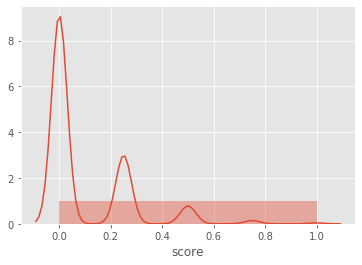

In [78]:
sns.distplot(df_final['score'], bins = 1);

In [79]:
df_final.to_csv('df_final.csv', index=False)

# ARCHITECTURE

In [80]:
user_id_inp_ = Input(shape=[1], name='user')
item_id_inp_ = Input(shape=[1], name='item')
brand_id_inp_ = Input(shape = [1], name = 'brand')

price_inp_ = Input(shape = [1], name = 'price')
score_inp_ = Input(shape = [1], name = 'score')

price_power_inp_ = Input(shape = [1], name = 'price_power')
score_power_inp_ = Input(shape = [1], name = 'power_score')

price_sqrt_inp_ = Input(shape = [1], name = 'price_sqrt')
score_sqrt_inp_ = Input(shape = [1], name = 'sqrt_score')

sequence_inp_ = Input(shape = (MAX_SEQUENCE_LENGTH, ), name = 'text')

Emb_size = 20
itemEmb_size = 50

userEmb = Embedding(output_dim=Emb_size, input_dim = customers_distinct.shape[0]+1,
                           input_length=1, name='userEmb')(user_id_inp_)
itemEmb = Embedding(output_dim=itemEmb_size, input_dim = items_distinct.shape[0]+1,
                           input_length=1, name='itemEmb')(item_id_inp_)
brandEmb = Embedding(output_dim=Emb_size, input_dim = brand_distinct.shape[0]+1,
                           input_length=1, name='brandEmb')(brand_id_inp_)

textEmb = Embedding(*matrix_emb.shape, weights = [matrix_emb], trainable = False)(sequence_inp_)

user_vectors = Reshape([Emb_size])(userEmb)
item_vectors = Reshape([itemEmb_size])(itemEmb)
brand_vectors = Reshape([Emb_size])(brandEmb)
text_flat = Flatten()(textEmb)

x1 = concatenate([user_vectors, item_vectors, brand_vectors, price_inp_, score_inp_,
                 price_power_inp_, score_power_inp_,
                 price_sqrt_inp_, score_sqrt_inp_, text_flat], name = 'PRODUCT_VECTOR')

x2 = Dropout(0.4)(x1)
x3 = Dense (512, activation = 'relu')(x2)
x4 = Dropout(0.3)(x3)
x5 = Dense(256, activation = 'relu')(x4)
x6 = Dropout(0.2)(x5)
x7 = Dense(128, activation = 'relu')(x6)
x8 = Dropout(0.2)(x7)

output = Dense(CATEGORICAL_ITEMS, activation = 'softmax' )(x8)

model = Model(inputs=[user_id_inp_, item_id_inp_, brand_id_inp_, price_inp_, sequence_inp_, score_inp_,
                     price_power_inp_, score_power_inp_,
                     price_sqrt_inp_, score_sqrt_inp_],
              outputs = output)

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['acc'])

model.summary()

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:497: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:115: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.float_val.extend([np.asscalar(x) for x in proto_values])
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
brand (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
text (InputLayer)               (None, 24)           0                                            
____________________________________________________________________________________________

In [81]:
def plot_training(history):
    plt.plot(history.history['acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [82]:
history = model.fit([df_final['session_idInt'], df_final['item_idInt'],
                     df_final['brand_id'], df_final['price'],
                     vec_data, df_final['score'],
                     df_final['price_power'], df_final['power_score'],
                     df_final['price_sqrt'], df_final['sqrt_score']],
                     encoded_items,
                     epochs = 3, #TODO: More epochs
                     batch_size = 256, verbose = 1,
                     shuffle = True)


Epoch 1/3
5217/5217 [==============================] - 5s 916us/step - loss: 8.0548 - acc: 0.0052
Epoch 2/3
5217/5217 [==============================] - 3s 666us/step - loss: 7.6952 - acc: 0.0205
Epoch 3/3
5217/5217 [==============================] - 3s 601us/step - loss: 7.2782 - acc: 0.0345


In [83]:
model.save('candidate_generation')

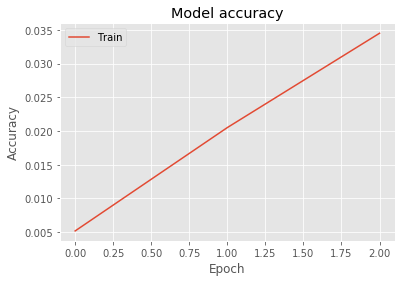

In [84]:
plot_training(history)

In [85]:
predictions_test = model.predict([df_final['session_idInt'], df_final['item_idInt'],
                     df_final['brand_id'], df_final['price'],
                     vec_data, df_final['score'],
                     df_final['price_power'], df_final['power_score'],
                     df_final['price_sqrt'], df_final['sqrt_score']],
                     verbose = 1)

5217/5217 [==============================] - 3s 585us/step


In [86]:
predictions_test.shape

(5217, 3202)

In [87]:
CUSTOMER = 2

In [88]:
top_10 = predictions_test[CUSTOMER].argsort()[-10:][::-1]

In [89]:
items_distinct[top_10][:10]

array(['598639', '363625', '526410', '580182', '600640', '2796579',
       '1672553', '197796', '526413', '595890'], dtype=object)

In [90]:
items_df_copy[items_df_copy['item_id'].isin(items_distinct[top_10])]

Empty DataFrame
Columns: [item_id, category, brand, title, image]
Index: []

# RANK MODEL

In [91]:
processed_data = df_final

In [92]:
items_distinct = processed_data.item_id.unique()
mappend_items = {i:val for i,val in enumerate(items_distinct)}
mappend_items_inv = {val:i for i,val in enumerate(items_distinct)}
mappend_items_text = processed_data.set_index('item_idInt').title.to_dict()

customers_distinct = processed_data.session_id.unique()
items_distinct = processed_data.item_id.unique()
brand_distinct = processed_data.brand.unique()

In [93]:
MAX_NB_WORDS = 30_000 
MAX_SEQUENCE_LENGTH = 24
EMBEDDING_DIM = 200

all_titles = processed_data['title']
all_titles = all_titles.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, )
tokenizer.fit_on_texts(all_titles)

data_sequences = tokenizer.texts_to_sequences(processed_data['title'])
vec_data = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3867 unique tokens.


In [94]:
model_W2V = Word2Vec.load('word2vec_model')

word_vecs = model_W2V.wv
size_vocab = len(word_index) + 1
matrix_emb = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in model_W2V:
        matrix_emb[i] = model_W2V[word]
    else:
        matrix_emb[i] = np.random.rand(1, EMBEDDING_DIM)[0]


del(word_vecs)

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [95]:
scaler = MinMaxScaler()
aux_scaling = processed_data[['price','score']]
data_scale = aux_scaling.values

In [96]:
def get_rank_model():
    user_id_inp_ = Input(shape=[1], name='user')
    item_id_inp_ = Input(shape=[1], name='item')
    brand_id_inp_ = Input(shape = [1], name = 'brand')

    price_inp_ = Input(shape = [1], name = 'price')

    price_power_inp_ = Input(shape = [1], name = 'price_power')

    price_sqrt_inp_ = Input(shape = [1], name = 'price_sqrt')


    

    Emb_size = 20
    itemEmb_size = 40

    userEmb = Embedding(output_dim=Emb_size, input_dim = customers_distinct.shape[0]+1,
                               input_length=1, name='userEmb')(user_id_inp_)
    itemEmb = Embedding(output_dim=itemEmb_size, input_dim = items_distinct.shape[0]+1,
                               input_length=1, name='itemEmb')(item_id_inp_)
    brandEmb = Embedding(output_dim=Emb_size, input_dim = brand_distinct.shape[0]+1,
                               input_length=1, name='brandEmb')(brand_id_inp_)

    

    user_vectors = Reshape([Emb_size])(userEmb)
    item_vectors = Reshape([itemEmb_size])(itemEmb)
    brand_vectors = Reshape([Emb_size])(brandEmb)
    x1 = concatenate([user_vectors, item_vectors, brand_vectors, price_inp_,
                     price_power_inp_,
                     price_sqrt_inp_], name = 'PRODUCT_VECTOR')

    x2 = Dropout(0.5)(x1)
    x3 = Dense (512, activation = 'relu', activity_regularizer=l1(0.0001))(x2)
    x4 = Dropout(0.4)(x3)
    x5 = Dense(256, activation = 'relu', activity_regularizer=l1(0.0001))(x4)
    x6 = Dropout(0.3)(x5)
    x7 = Dense(128, activation = 'relu',activity_regularizer=l1(0.0001))(x6)
    x8 = Dropout(0.2)(x7)

    output = Dense(1, activation = 'linear' )(x8)

    model = Model(inputs=[user_id_inp_, item_id_inp_, brand_id_inp_, price_inp_,
                         price_power_inp_,
                         price_sqrt_inp_],
                  outputs = output)

    model.compile(loss = 'mse',
                  optimizer = 'rmsprop',
                  metrics = ['acc'])

    model.summary()

    return model

In [97]:

rank_model = get_rank_model()

history = rank_model.fit([processed_data['session_idInt'], processed_data['item_idInt'],
                     processed_data['brand_id'], processed_data['price'],
                     processed_data['price_power'],
                     processed_data['price_sqrt']],
                     processed_data['original_score'],
                     epochs = 3,
                     batch_size = 256,
                     shuffle = True)

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:497: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:115: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.float_val.extend([np.asscalar(x) for x in proto_values])
C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
brand (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
userEmb (Embedding)             (None, 1, 20)        43820       user[0][0]                       
____________________________________________________________________________________________

In [98]:
rank_model.save('rank_model')

In [99]:
preds = rank_model.predict([processed_data['session_idInt'], processed_data['item_idInt'],
                     processed_data['brand_id'], processed_data['price'],
                     processed_data['price_power'],
                     processed_data['price_sqrt']], verbose = 1)

5217/5217 [==============================] - 1s 206us/step


In [100]:
c_indexes = processed_data.index[processed_data['session_idInt'] == 128]
processed_data[processed_data['session_idInt'] == 128]

session_id               date_time item_id  \
183  8f979d7bb3a99f87ee281b821bd1b71c 2020-07-27 01:14:10.418  281216   

        price brand                                    title  hour  weekday  \
183  0.272376   nan  sapateira portas espelho carraro branco     1        1   

     session_idInt  item_idInt  brand_id  score  original_score  price_power  \
183            128         137         0    0.0               1     0.074189   

     power_score  price_sqrt  sqrt_score  
183          0.0    0.521896         0.0

In [101]:
preds[c_indexes]

array([[0.98795605]], dtype=float32)

In [102]:
indexes_customers_map = {i:val for i,val in enumerate(processed_data['session_idInt'])}
indexes_customers_df = pd.DataFrame({'indexes': processed_data.index.values, 'session_idInt': processed_data.session_idInt})
indexes_customers_df.head()

indexes  session_idInt
0        0              0
1        1              1
2        2              2
3        3              3
4        4              4

In [103]:
items_distinct = processed_data.item_id.unique() 
customers_distinct = processed_data.session_id.unique()
mappend_items = {i:val for i,val in enumerate(items_distinct)}
mappend_items_inv = {val:i for i,val in enumerate(items_distinct)}
mappend_items_text = processed_data.set_index('item_idInt').title.to_dict()

mappend_items_brand = processed_data.set_index('item_idInt').brand_id.to_dict()
mappend_items_price = processed_data.set_index('item_idInt').price.to_dict()
mappend_items_price_power = processed_data.set_index('item_idInt').price_power.to_dict()
mappend_items_price_sqrt = processed_data.set_index('item_idInt').price_sqrt.to_dict()

customers_distinct = processed_data.session_id.unique()
items_distinct = processed_data.item_id.unique()
brand_distinct = processed_data.brand.unique()

In [104]:
MAX_NB_WORDS = 30_000 
MAX_SEQUENCE_LENGTH = 24 
EMBEDDING_DIM = 100 

all_titles = processed_data['title']
all_titles = all_titles.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, )
tokenizer.fit_on_texts(all_titles)

data_sequences = tokenizer.texts_to_sequences(processed_data['title'])
vec_data = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3867 unique tokens.


#### We need to create a dictionary to map the items_id to their corresponding text vector

In [105]:
vec_mappend_items_text = processed_data.set_index('item_idInt').title.to_dict()
vec_data_sequences = tokenizer.texts_to_sequences(vec_mappend_items_text.values())
vec_data_seq = pad_sequences(vec_data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [106]:
for i in vec_mappend_items_text.keys():
    vec_mappend_items_text[i] = vec_data_seq[i]

## Models

In [107]:
model_cands = load_model('candidate_generation')
ranking_model = load_model('rank_model')

In [108]:
input_length = len(ranking_model.input_shape)

In [109]:
def rec_engine(customer, N = 5):

    _data = processed_data[processed_data['session_idInt'] == customer]
    _vec_data = vec_data[_data.index]
    _cands = model_cands.predict([_data['session_idInt'], _data['item_idInt'],
                             _data['brand_id'], _data['price'],
                             _vec_data, _data['score'],
                             _data['price_power'], _data['power_score'],
                             _data['price_sqrt'], _data['sqrt_score']],
                             verbose = 1)
    _cands = pd.DataFrame(_cands)
    _cands['session_idInt'] = customer
    _cands = _cands.groupby(['session_idInt']).max()
    RANKING_ITEMS = 50
    cands = np.zeros((RANKING_ITEMS))
    del _cands.index.name

    cands = _cands.values.reshape(_cands.shape[1]).argsort()[-RANKING_ITEMS:][::-1]
    cands = cands.astype(int)

    X = np.zeros((input_length, RANKING_ITEMS), dtype = object)
    X_vec = np.zeros((RANKING_ITEMS, MAX_SEQUENCE_LENGTH), dtype = object)
    print(X.shape)
    for row in range(cands.shape[0]):
        X[0, row] = processed_data['session_idInt'][row] #Customer_Id
        X[1, row] = cands[row] #Item_Id
        X[2, row] = mappend_items_brand[cands[row]]
        X[3, row] = mappend_items_price[cands[row]]
        X[4, row] = mappend_items_price_power[cands[row]]
        X[5, row] = mappend_items_price_sqrt[cands[row]]
        X_vec[row] = vec_mappend_items_text[cands[row]]

    preds = ranking_model.predict([X[0], X[1],  X[2],
                                X[3], X[4],
                                X[5]], verbose = 1)

    predictions_ranked = preds.reshape(RANKING_ITEMS)
    print('\n' + '=='*30 + '\n')
    print(f'\nThe customer number {customer} viewed these items: ')
    print('\n' + '=='*30 + '\n')
    viewed_items = processed_data[['title', 'original_score']][processed_data['session_idInt'] == customer].groupby('title')\
                        .sum().reset_index().sort_values(['original_score'], ascending = False)
    print('\n'.join([str(i+1) + str(' - ') + str(x) for i, x in enumerate(viewed_items['title'].values[0:20])]))
    top = predictions_ranked.argsort()[-N:][::-1] #items positions
    print (f'\n===================== TOP {N} Recommended Products =====================')
    print('\n'.join([str(i+1) + str(' - ') + str(mappend_items_text[x]) for i, x in enumerate(top)]))
    print ("==================================================================")

In [110]:
rec_engine(customer = 0, N = 10)

1/1 [==============================] - 1s 683ms/step
(6, 50)
50/50 [==============================] - 1s 11ms/step



The customer number 0 viewed these items: 


1 - painel tv polegada nicho mister espresso movel whitepinho

===================== TOP 10 Recommended Products =====================
1 - armario aereo servico portas espresso movel nogalbranco
2 - bicicleta caloi sweet
3 - rack painel tv polegada samba espresso movel whitenogueira
4 - cantinho cafe aconchego cor branco
5 - estante livro prateleiras charge siena movel
6 - cabeceira casal extensivel criado mudo gaveta elegance espresso movel demolicao
7 - guarda roupa solteiro portas gaveta internas a534 smart kappesberg branco
8 - comoda formula vermelho
9 - sofa cama madeira macica castanho atraente moveis
10 - poltrona duda siena movel chocomedina
